#### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers, regularizers
import matplotlib.colors as mcolors
import seaborn as sns
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#### loading and displaying the datasets

In [2]:
train=pd.read_csv('SQLIV3_cleaned2.csv')
test=pd.read_csv('sqliv2_utf8.csv')
print(train)

                                                Sentence  Label
0                      " or pg_sleep  (  __TIME__  )  --      1
1      create user name identified by pass123 tempora...      1
2       AND 1  =  utl_inaddr.get_host_address   (    ...      1
3       select * from users where id  =  '1' or @ @1 ...      1
4       select * from users where id  =  1 or 1#"  ( ...      1
...                                                  ...    ...
30609              DELETE FROM door WHERE grow = 'small'      0
30610                               DELETE FROM tomorrow      0
30611                       SELECT wide ( s )  FROM west      0
30612       SELECT * FROM  ( SELECT slide FROM breath )       0
30613                           SELECT TOP 3 * FROM race      0

[30614 rows x 2 columns]


In [3]:
train.Label.value_counts()


0    19268
1    11346
Name: Label, dtype: int64

#### 'Label' Data Distribution


Text(0.5, 1.0, 'Label')

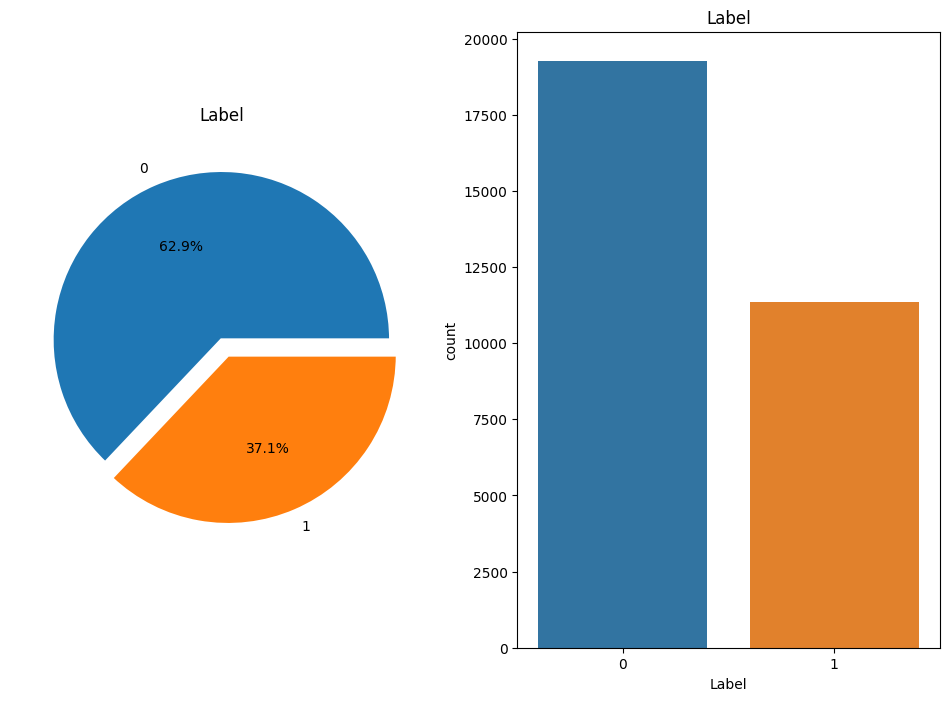

In [4]:
f, ax = plt.subplots(1, 2, figsize=(12, 8))
colors = list(mcolors.TABLEAU_COLORS.values())
train['Label'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'antialiased': True}, colors=colors)

ax[0].set_title('Label')
ax[0].set_ylabel('')
sns.countplot(x='Label', data=train, ax=ax[1], palette=colors)
ax[1].set_title('Label')

In [5]:
train_x = train['Sentence'].values
train_y = train['Label'].values

test_x = test['Sentence'].values
test_y = test['Label'].values

#### Text Vectorization

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=3000)
train_x = vectorizer.fit_transform(train_x).toarray()


#### Model Configuration

In [7]:
hidden_units1=512
hidden_units2=256
hidden_units3=128
learning_rate=0.01
hidden_layer_act='relu'
output_layer_act='sigmoid'
no_epochs=27

In [ ]:
model = Sequential()
model.add(Dense(hidden_units1, input_dim=3000, activation=hidden_layer_act))
model.add(Dense(hidden_units2, activation=hidden_layer_act))
model.add(Dense(hidden_units3, activation=hidden_layer_act))
model.add(Dense(1, activation=output_layer_act))  

#### Compilation

In [9]:
sgd=optimizers.SGD(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy',optimizer=sgd, metrics=['accuracy'])

#### Model training

In [10]:
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

In [11]:
history = model.fit(train_x, train_y, epochs=no_epochs, batch_size=32, verbose=2, validation_split=0.2,callbacks=[early_stop])


Epoch 1/27
766/766 - 13s - loss: 0.6707 - accuracy: 0.6293 - val_loss: 0.6536 - val_accuracy: 0.9993
Epoch 2/27
766/766 - 16s - loss: 0.5856 - accuracy: 0.8651 - val_loss: 0.5747 - val_accuracy: 0.9417
Epoch 3/27
766/766 - 16s - loss: 0.3125 - accuracy: 0.9328 - val_loss: 0.2410 - val_accuracy: 0.9809
Epoch 4/27
766/766 - 15s - loss: 0.1480 - accuracy: 0.9550 - val_loss: 0.1508 - val_accuracy: 0.9758
Epoch 5/27
766/766 - 16s - loss: 0.1033 - accuracy: 0.9620 - val_loss: 0.1387 - val_accuracy: 0.9682
Epoch 6/27
766/766 - 15s - loss: 0.0822 - accuracy: 0.9711 - val_loss: 0.0623 - val_accuracy: 0.9851
Epoch 7/27
766/766 - 15s - loss: 0.0689 - accuracy: 0.9787 - val_loss: 0.0789 - val_accuracy: 0.9775
Epoch 8/27
766/766 - 14s - loss: 0.0595 - accuracy: 0.9851 - val_loss: 0.0603 - val_accuracy: 0.9807
Epoch 9/27
766/766 - 15s - loss: 0.0530 - accuracy: 0.9883 - val_loss: 0.0340 - val_accuracy: 0.9900
Epoch 10/27
766/766 - 15s - loss: 0.0483 - accuracy: 0.9902 - val_loss: 0.0386 - val_accura

#### Final Training Metrics Display

In [12]:

print("Final Training Loss:", history.history['loss'][-1])
print("Final Training Accuracy:", history.history['accuracy'][-1])



Final Training Loss: 0.0337163582444191
Final Training Accuracy: 0.9935078024864197


In [13]:
model.save('mlp.h5')


#### Plotting Loss and Accuracy over Epochs


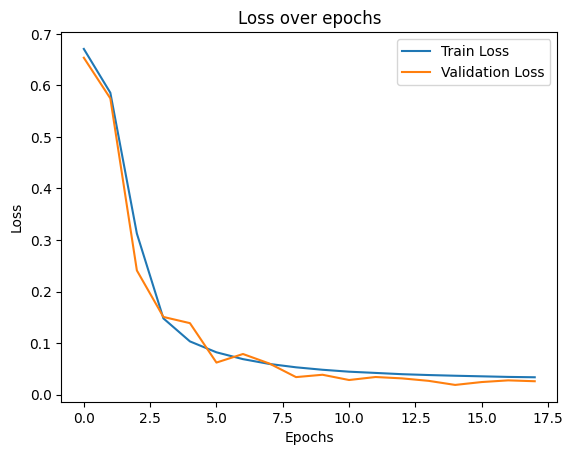

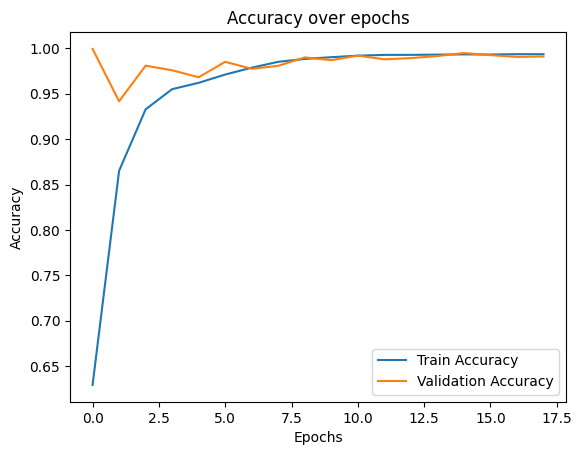

In [14]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
test_x = test['Sentence'].values
test_y = test['Label'].values
print(test.isnull().sum())


Sentence    3
Label       0
dtype: int64


In [16]:
test = test.dropna(subset=['Sentence'])



#### Filter Only SQL Injection (Label = 1)


In [17]:
# Filtrer les lignes où Label == 1
filtered = test[test['Label'] == 1]

# Supprimer les doublons en gardant la première occurrence
filtered = filtered.drop_duplicates(subset='Sentence', keep='first')

# Récupérer les 1000 exemples dans test_x et test_y
test_x = filtered['Sentence'].values
test_y = filtered['Label'].values

test_x = vectorizer.transform(test_x).toarray()


#### Prediction and Metrics Evaluation


In [18]:
predictions = model.predict(test_x)


In [19]:
# Convertir les probabilités en classes binaires
predicted_classes = (predictions >= 0.5).astype(int)

# Afficher les 20 premières prédictions
print(predicted_classes.flatten())


[1 1 1 ... 1 1 1]


In [20]:
# Compter le nombre de prédictions égales à 1
nombre_de_sql_injections = (predicted_classes == 1).sum()

print(f"number of query detected as SQL injection  : {nombre_de_sql_injections}")


number of query detected as SQL injection  : 11272


In [21]:
test.Label.value_counts()


0    22304
1    11453
Name: Label, dtype: int64

In [22]:



print(f"number of query detected as SQL injection : {nombre_de_sql_injections} / {len(test_x)}")
print(f"Accuracy  : {accuracy_score(test_y, predicted_classes) * 100:.2f}%")
print(f"Precision : {precision_score(test_y, predicted_classes, zero_division=0) * 100:.2f}%")
print(f"Recall : {recall_score(test_y, predicted_classes, zero_division=0) * 100:.2f}%")
print(f"F1 Score : {f1_score(test_y, predicted_classes, zero_division=0) * 100:.2f}%")


number of query detected as SQL injection : 11272 / 11424
Accuracy  : 98.67%
Precision : 100.00%
Recall : 98.67%
F1 Score : 99.33%


#### Filter Only Normal Queries (Label = 0)


In [23]:

filtered2 = test[test['Label'] == 0]
filtered2 = filtered2.drop_duplicates(subset='Sentence', keep='first')


test_x2 = filtered2['Sentence'].values
test_y2 = filtered2['Label'].values


test_x2 = vectorizer.transform(test_x2).toarray()

#### Prediction and Metrics Evaluation


In [24]:
predictions2 = model.predict(test_x2)


In [25]:
# Convertir les probabilités en classes binaires
predicted_classes2 = (predictions2 >= 0.5).astype(int)

# Afficher les 20 premières prédictions
print(predicted_classes2.flatten())


[0 0 0 ... 0 0 0]


In [26]:

nombre_de_non_sql_injections = (predicted_classes2 == 0).sum()

print(f"Nombre detected as normal query : {nombre_de_non_sql_injections}")


Nombre detected as normal query : 22146


In [27]:
test.Label.value_counts()


0    22304
1    11453
Name: Label, dtype: int64

In [28]:

print(f"Nombre detected as normal query : {nombre_de_non_sql_injections} / {len(test_x2)}")

# Métriques adaptées à la classe 0
print(f"Accuracy : {accuracy_score(test_y2, predicted_classes2) * 100:.2f}%")
print(f"Precision (classe 0) : {precision_score(test_y2, predicted_classes2, zero_division=0, pos_label=0) * 100:.2f}%")
print(f"Recall (classe 0) : {recall_score(test_y2, predicted_classes2, zero_division=0, pos_label=0) * 100:.2f}%")
print(f"F1 Score (classe 0) : {f1_score(test_y2, predicted_classes2, zero_division=0, pos_label=0) * 100:.2f}%")


Nombre detected as normal query : 22146 / 22303
Accuracy : 99.30%
Precision (classe 0) : 100.00%
Recall (classe 0) : 99.30%
F1 Score (classe 0) : 99.65%
